# Random Forest Classifier

The Random Forest Classifier was chosen to run on this dataset because it is one of the most effective models for classification tasks. The objective of this model will be to classify whether a patient is diagnosed with Alzheimers. There are several things to consider when creating a random forest classifier.

### Random Forest Considerations
1. **Number of Decision Trees**
    - The number of decision trees that the random forest model uses will be determined by testing different numbers of decision trees (10, 20, 30,...,200) and selecting the number that produces the highest % accuracy.
2. **Train | Test Split**
    -  Cross Validation was chosen as a method to split the data into a training and testing set because it maximizes the amount of data that the classifier can use for testing.
    1. *Cross Validation*
    2. *80/20 Split*
3. **Balancing Data**
    - The data has aproximately twice as many negative examples as it does positive examples. (1,389 neg, 760 pos)
    - Two different data balancing techniques will be tested and the balancing technique that produces the best performance will be chosen for the final model.
    1. *Oversampling*
    2. *Bagging*
4. **Feature Selection**
    1. *Removing irrelevant features*



In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline

## <span style="color:green"> **Initial Testing** </span>

- Before altering the model or data in any way, the random forest model was run to get a baseline for its performance.
- Throughout testing I will use ```random_state = 42``` when necessary for the sake of replicability and to control for random selection of data.
    - When not explicitly controlling for random state, the models will be run 10 times and the accuracy will be averaged.


Initial RF Accuracy: 0.9193023255813954


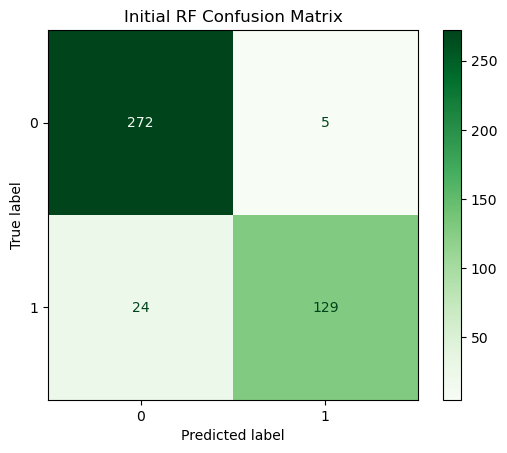

In [6]:
#import data
df_data = pd.read_csv("alzheimers_disease_data.csv")

#remove PatientID and DoctorInCharge cols so they don't get used in RF
df_data.drop(["PatientID","DoctorInCharge"], axis=1, inplace=True)

#separate test and training data
df_X = df_data.drop(["Diagnosis"],axis=1)
df_y = df_data["Diagnosis"]

#create training and test subsets
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, 
                                                    test_size=0.2, random_state=42)
#list for iterating trials
initial_trials = [x for x in range(1,11)]

#accumulative accuracy
initial_acc = 0


for trial in initial_trials:
    #Calculating RF classifier
    rf = RandomForestClassifier(n_estimators=50)
    rf.fit(X_train, y_train)
    score = rf.score(X_test, y_test)
    initial_acc += score

print(f"Initial RF Accuracy: {initial_acc/len(initial_trials)}")

#confusion matrix
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Greens')
plt.title("Initial RF Confusion Matrix")

#save plot
plt.savefig("initial_rf_cm.png", dpi=300)

# Visualize plot
plt.show()


## <span style="color:green"> _**Initial Conclusion**_ </span>

The initial accuracy of 92% is a good indicator that the Random Forest model works well for this data set.

The confusion matrix indicates that the model erred toward predicting false negatives rather than false positives.


## <span style="color:blue"> **Determining N Trees for Random Forest Classifier** </span>

Using ```random_state=42``` to control for randomness in selecting data.

avg performance: 0.9238372093023258


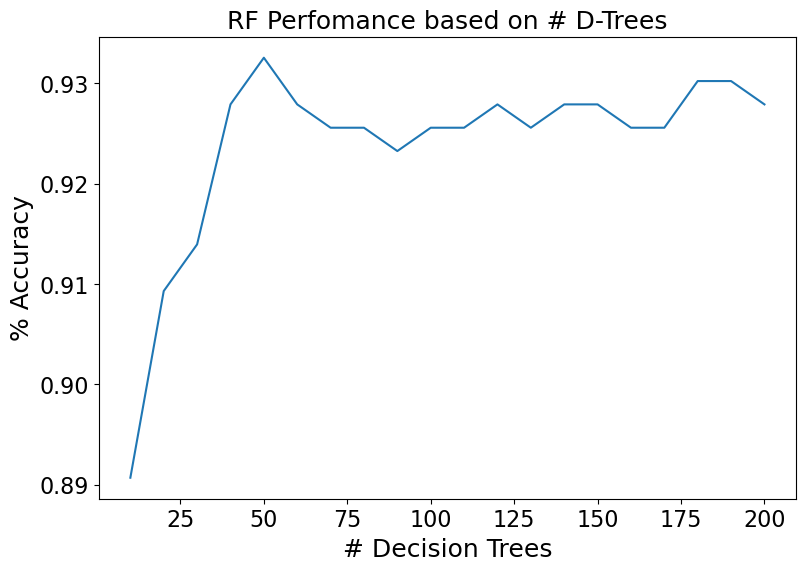

In [8]:
#import data
df_data = pd.read_csv("alzheimers_disease_data.csv")

#remove PatiendID and DoctorInCharge cols so they don't get used in RF
df_data.drop(["PatientID","DoctorInCharge"], axis=1, inplace=True)

#separate X and y variables
df_train = df_data.drop(["Diagnosis"],axis=1)
df_test = df_data["Diagnosis"]

#create training and test subsets
X_train, X_test, y_train, y_test = train_test_split(df_train, df_test, 
                                                    test_size=0.2, random_state=42)

#list for # of decision trees
d_trees = [x for x in range(10,210) if x % 10 == 0]

#storing results
tree_results = []
tree_acc = 0

for tree in d_trees:
    rf = RandomForestClassifier(n_estimators=tree, random_state=42)
    rf.fit(X_train, y_train)
    tree_results.append((tree,rf.score(X_test,y_test)))
    tree_acc += rf.score(X_test,y_test)

print(f"avg performance: {tree_acc / len(d_trees)}")

# Plot of rf accuracy based on changes in estimator amount
plt.figure(figsize=(9,6))
#get only % accurate values from tuples
accuracy = [val[1] for val in tree_results]
plt.plot(d_trees, accuracy)

# labels for graph
plt.title("RF Perfomance based on # D-Trees", fontsize=18)
plt.xlabel("# Decision Trees", fontsize = 18)
plt.ylabel("% Accuracy", fontsize = 18)
plt.tick_params(labelsize = 16)

#save plot
plt.savefig("rf_num_dtrees.png", dpi=300)

# Visualize plot
plt.show()


## <span style="color:purple"> **Cross Validation** </span>

### <span style="color:purple"> 1. Determining # Folds</span>

avg performance: 0.936844594442929


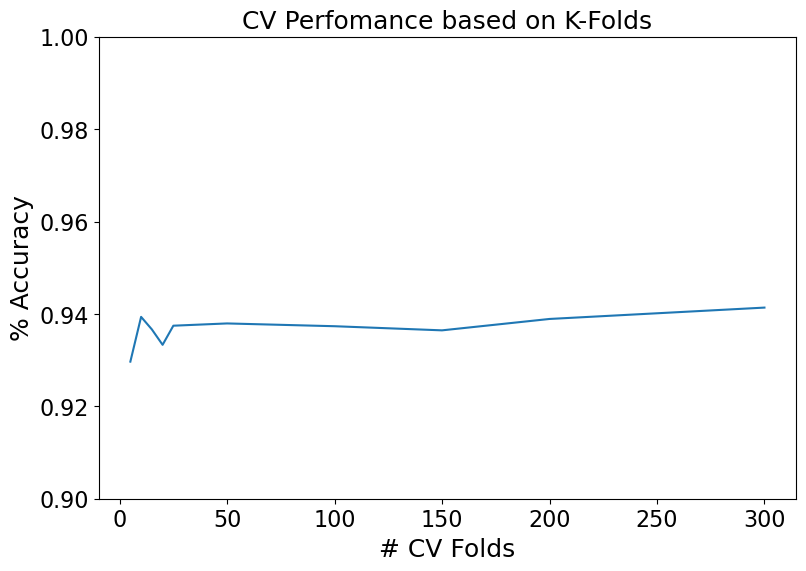

In [10]:
#***This cell is computationall expensive - takes about 2min ***

#import data
df_data = pd.read_csv("alzheimers_disease_data.csv")

#remove PatiendID and DoctorInCharge cols so they don't get used in RF
df_data.drop(["PatientID","DoctorInCharge"], axis=1, inplace=True)

#separate data in X and y variables
df_X = df_data.drop(["Diagnosis"],axis=1)
df_y = df_data["Diagnosis"]

#lists to store results from for loop
#LOOCV took about 6 minutes to run and had an accuracy of about 94%
folds = [5,10,15,20,25,50,100,150,200,300]
cv_results = []
cv_acc = 0

for fold in folds:
    #creating k-fold splits
    #must do this because it has the shuffle feature like trian_test_split
    kf = KFold(n_splits=fold, shuffle=False)
    
    #Calculating RF classifier using cross validation
    cv_score = cross_val_score(RandomForestClassifier(n_estimators=50),
                               df_X, df_y, cv=kf)
    cv_results.append((fold, np.average(cv_score))) #adding results to result list
    cv_acc += np.average(cv_score) #averaging all fold accuracies
    
print(f"avg performance: {cv_acc / len(folds)}")

# Plot of cv accuracy based on changes in fold count
plt.figure(figsize=(9,6))
#get only % accurate values from tuples
accuracy = [val[1] for val in cv_results]
plt.plot(folds, accuracy)

# labels for graph
plt.title("CV Perfomance based on K-Folds", fontsize=18)
plt.xlabel("# CV Folds", fontsize = 18)
plt.ylabel("% Accuracy", fontsize = 18)
plt.ylim(.90,1)
plt.tick_params(labelsize = 16)

#save plot
plt.savefig("cv_num_folds.png", dpi=300)

# Visualize plot
plt.show()

### <span style="color:purple"> 2. Calculating Average CV Score</span>

avg performance: 0.9364784527518172


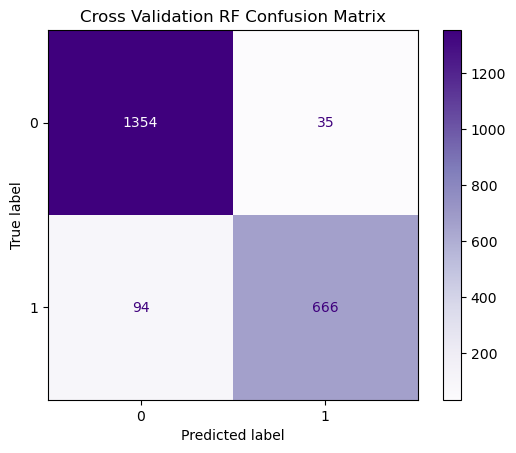

In [12]:
#import data
df_data = pd.read_csv("alzheimers_disease_data.csv")

#remove PatiendID and DoctorInCharge cols so they don't get used in RF
df_data.drop(["PatientID","DoctorInCharge"], axis=1, inplace=True)

#separate data in X and y variables
df_X = df_data.drop(["Diagnosis"],axis=1)
df_y = df_data["Diagnosis"]

#accumulative accuracy
cv_acc = 0

for x in range(1,11):
    #creating k-fold splits
    #must do this because it has the shuffle feature like trian_test_split
    kf = KFold(n_splits=20, shuffle=True)
    
    #Calculating RF classifier using cross validation
    cv = cross_validate(RandomForestClassifier(n_estimators=50),
                               df_X, df_y, cv=kf)
    cv_acc += np.average(cv['test_score'])

print(f"avg performance: {cv_acc / 10}")

#Confusion Matrix
#For CV, to get the confusion matrix, cross_val_predict must be called
y_pred_cv = cross_val_predict(RandomForestClassifier(n_estimators=50),
                               df_X, df_y, cv=kf)
cm_cv = confusion_matrix(df_y, y_pred_cv)
ConfusionMatrixDisplay(confusion_matrix=cm_cv).plot(cmap='Purples')
plt.title("Cross Validation RF Confusion Matrix")

#save plot
plt.savefig("cv_conf_matrx.png", dpi=300)

plt.show()

## <span style="color:purple"> _**Cross Validation Conclusion**_ </span>

1. Determining # folds
    1. Accuracy did not vary much as the number of folds increased, so k=10 will be used as it is a common number of folds and happens to be approximately the best performing number of folds.
2. Calculating Average performance
    1. The average performance of the RF model improved about 1 percent from the typical 80/20 split of training and test data
    2. There will likely be a greater improvement once the data is balanced
    3. The model is still gerenating more false-negatives than it is false-positives

## <span style="color:red"> **Balancing Data** </span>
### <span style="color:red"> 1A. Oversampling </span>

- The oversampled csv file was created using the Jupyter Notebook "create_oversampled.ipynb"
    - Total = 2,778, positive = 1,389, negative = 1,389
- Once the data was balanced, the file was tested on the random forest model using a train/test split of 20% and using cross validation
  


Oversampled RF Accuracy: 0.9595323741007192


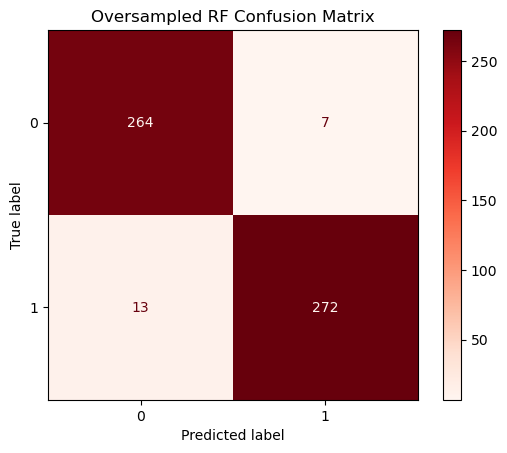

In [15]:
#Oversampled data
df_data_over = pd.read_csv("alzheimers_disease_data_oversampled.csv")

#remove PatiendID and DoctorInCharge cols so they don't get used in RF
df_data_over.drop(["PatientID","DoctorInCharge"], axis=1, inplace=True)

#separate test and training data
df_X_over = df_data_over.drop(["Diagnosis"],axis=1)
df_y_over = df_data_over["Diagnosis"]

#create training and test subsets
X_train, X_test, y_train, y_test = train_test_split(df_X_over, df_y_over, 
                                                    test_size=0.2)
#accumulative accuracy
over_acc = 0

for x in range(1,11):
    #Calculating RF classifier
    rf_over = RandomForestClassifier(n_estimators=50)
    rf_over.fit(X_train, y_train)
    over_acc += rf_over.score(X_test, y_test)

print(f"Oversampled RF Accuracy: {over_acc/10}")

#confusion matrix
y_pred_over = rf_over.predict(X_test)
cm_over = confusion_matrix(y_test, y_pred_over)
ConfusionMatrixDisplay(confusion_matrix=cm_over).plot(cmap='Reds')
plt.title("Oversampled RF Confusion Matrix")

#save plot
plt.savefig("oversampled_rf_cm.png", dpi=300)

#display plot
plt.show()


### <span style="color:red"> 1B. Oversampling + CV </span>

avg performance: 0.9654777916796998


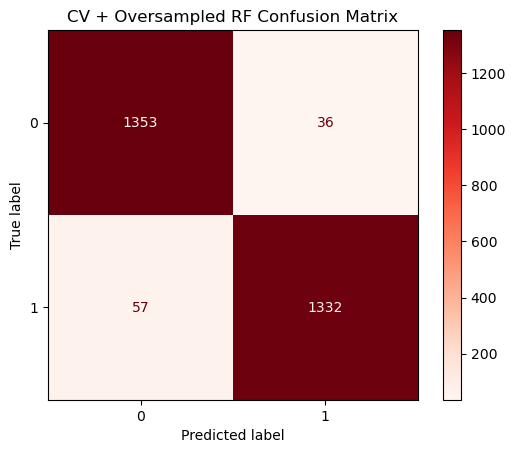

In [17]:
#Oversampled data
df_data = pd.read_csv("alzheimers_disease_data_oversampled.csv")

#remove PatiendID and DoctorInCharge cols so they don't get used in RF
df_data.drop(["PatientID","DoctorInCharge"], axis=1, inplace=True)

#separate data in X and y variables
df_X = df_data.drop(["Diagnosis"],axis=1)
df_y = df_data["Diagnosis"]

#accumulative accuracy
cv_ovr_acc = 0

for x in range(1,11):
    #creating k-fold splits
    #must do this because it has the shuffle feature like trian_test_split
    kf = KFold(n_splits=20, shuffle=True)
    
    #Calculating RF classifier using cross validation
    cv = cross_validate(RandomForestClassifier(n_estimators=50),
                               df_X, df_y, cv=kf)
    cv_ovr_acc += np.average(cv['test_score'])

print(f"avg performance: {cv_ovr_acc / 10}")

#Confusion Matrix
#For CV, to get the confusion matrix, cross_val_predict must be called
y_pred_cv_ovr = cross_val_predict(RandomForestClassifier(n_estimators=50),
                               df_X, df_y, cv=kf)
cm_cv_ovr = confusion_matrix(df_y, y_pred_cv_ovr)
ConfusionMatrixDisplay(confusion_matrix=cm_cv_ovr).plot(cmap='Reds')
plt.title("CV + Oversampled RF Confusion Matrix")

#save plot
plt.savefig("cv_ovr_cm.png", dpi=300)

plt.show()

### <span style="color:red"> 2A. Bagging </span>

#### <span style="color:red"> Determining # Bags</span>

Bagged RF Accuracy: 0.9362790697674418


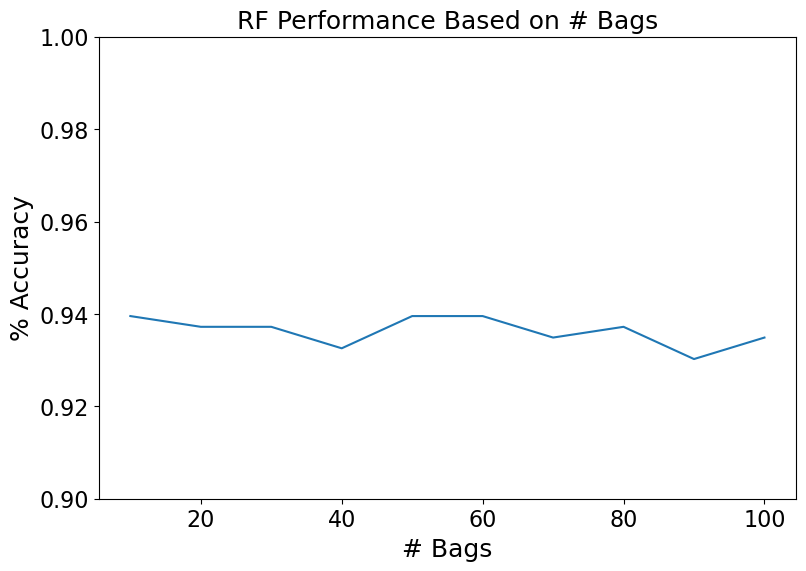

In [19]:
#import data
df_data_bag = pd.read_csv("alzheimers_disease_data.csv")

#remove PatientID and DoctorInCharge cols so they don't get used in RF
df_data_bag.drop(["PatientID","DoctorInCharge"], axis=1, inplace=True)

#separate X and y variables
df_X_bag = df_data_bag.drop(["Diagnosis"],axis=1)
df_y_bag = df_data_bag["Diagnosis"]

#create training and test subsets
X_train, X_test, y_train, y_test = train_test_split(df_X_bag, df_y_bag, 
                                                  test_size=0.2)

bag_estimators = [x for x in range(10,110) if x % 10 == 0]
bag_results = []
bag_acc = 0

#Calculating the bagged RF classifier
for bag in bag_estimators:
    rf_bag = BaggingClassifier(estimator=RandomForestClassifier(n_estimators=50),
                               n_estimators=bag)
    rf_bag.fit(X_train, y_train)
    score_bag = rf_bag.score(X_test, y_test)
    bag_results.append((bag,score_bag))
    bag_acc += score_bag

print(f"Bagged RF Accuracy: {bag_acc / len(bag_estimators)}")
bag_results

# Plot of cv accuracy based on changes in fold count
plt.figure(figsize=(9,6))
#get only % accurate values from tuples
accuracy = [val[1] for val in bag_results]
plt.plot(bag_estimators, accuracy)

# labels for graph
plt.title("RF Performance Based on # Bags", fontsize=18)
plt.xlabel("# Bags", fontsize = 18)
plt.ylabel("% Accuracy", fontsize = 18)
plt.ylim(.90,1)
plt.tick_params(labelsize = 16)

#save plot
plt.savefig("bagging_rf_accuracy.png", dpi=300)

#display plot
plt.show()

### <span style="color:red"> 2A. Bagging </span>

#### <span style="color:red"> Calculating Average Bagging Score</span>

Bagged RF Accuracy: 0.9116279069767442


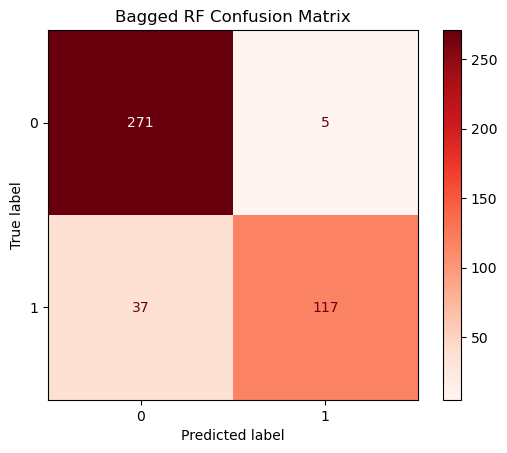

In [21]:
#import data
df_data_bag = pd.read_csv("alzheimers_disease_data.csv")

#remove PatientID and DoctorInCharge cols so they don't get used in RF
df_data_bag.drop(["PatientID","DoctorInCharge"], axis=1, inplace=True)

#separate X and y variables
df_X_bag = df_data_bag.drop(["Diagnosis"],axis=1)
df_y_bag = df_data_bag["Diagnosis"]

#create training and test subsets
X_train, X_test, y_train, y_test = train_test_split(df_X_bag, df_y_bag, 
                                                  test_size=0.2)

#accumulated accuracy
bag_acc = 0

#Calculating the bagged RF classifier
for x in range(1,11):
    rf_bag = BaggingClassifier(estimator=RandomForestClassifier(n_estimators=50),
                               n_estimators=10)
    rf_bag.fit(X_train, y_train)
    score_bag = rf_bag.score(X_test, y_test)
    bag_acc += score_bag

print(f"Bagged RF Accuracy: {bag_acc / 10}")

#confusion matrix
y_pred_bag = rf_bag.predict(X_test)
cm_bag = confusion_matrix(y_test, y_pred_bag)
ConfusionMatrixDisplay(confusion_matrix=cm_bag).plot(cmap='Reds')
plt.title("Bagged RF Confusion Matrix")

#save plot
plt.savefig("bagged_rf_cm.png", dpi=300)

#display plot
plt.show()


## <span style="color:red"> _**Balancing Data Conclusion**_ </span>

1. Oversampling has the highest performance, giving a significant boost of about 4%
    1. The oversampled data also fixed the model's overprediction of negative results
    2. Oversampling with cross validation performed about the same as just oversampling with RF
2. Bagging produced the worst performance so far, performing about as poorly, if not more poorly, than simply using the 80/20 split on RF
    1. Bagging also did not correct false negatives
       - I think this is the case because selecting a random subset of data that is so heavily skewed toward negative examples is likely to produced subsets that are also skewed toward negative examples.



## **Feature Selection**

The Random Forest Classifier randomly chooses features, but it is possible removing irrelevant features could improve the efficiency of the model without sacrificing accuracy. 

### Option 1: Remove only the most irrelevant features
Based on the information gained during feature selection, any feature with less than 0.01 correlation will be removed. 

Removed Features:
- DifficultyCompletingTasks
- DietQuality
- CholesterolTotal
- PhysicalActivity
- DiastolicBP
- Foregetfulness
- Smoking
- Age
- Depression
- AlcoholConsumption

avg performance: 0.9662013867167136


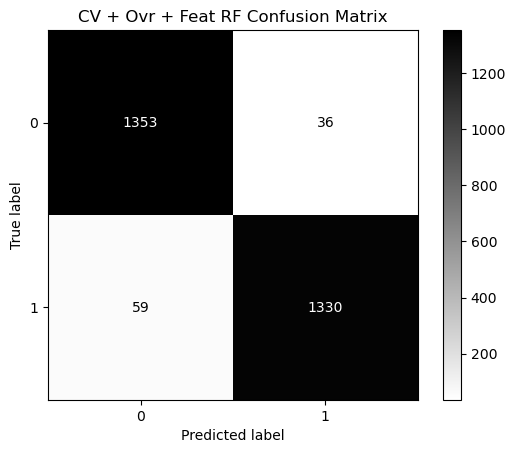

In [27]:
#Oversampled data
df_data = pd.read_csv("alzheimers_disease_data_oversampled.csv")

#remove PatiendID and DoctorInCharge cols so they don't get used in RF
df_data.drop(["PatientID","DoctorInCharge","DifficultyCompletingTasks",
             "DietQuality","CholesterolTotal","PhysicalActivity",
             "DiastolicBP","Forgetfulness","Smoking","Age","Depression",
             "AlcoholConsumption"], axis=1, inplace=True)

#separate data in X and y variables
df_X = df_data.drop(["Diagnosis"],axis=1)
df_y = df_data["Diagnosis"]

#accumulative accuracy
cv_ovr_acc = 0

for x in range(1,11):
    #creating k-fold splits
    #must do this because it has the shuffle feature like trian_test_split
    kf = KFold(n_splits=20, shuffle=True)
    
    #Calculating RF classifier using cross validation
    cv = cross_validate(RandomForestClassifier(n_estimators=50),
                               df_X, df_y, cv=kf)
    cv_ovr_acc += np.average(cv['test_score'])

print(f"avg performance: {cv_ovr_acc / 10}")

#Confusion Matrix
#For CV, to get the confusion matrix, cross_val_predict must be called
y_pred_cv_ovr = cross_val_predict(RandomForestClassifier(n_estimators=50),
                               df_X, df_y, cv=kf)
cm_cv_ovr = confusion_matrix(df_y, y_pred_cv_ovr)
ConfusionMatrixDisplay(confusion_matrix=cm_cv_ovr).plot(cmap='gray_r')
plt.title("CV + Ovr + Feat RF Confusion Matrix")

#save plot
plt.savefig("cv_ovr_feat_cm.png", dpi=300)

plt.show()


### Option 2: Keep only the most relevant features
Remaining Features:
- FunctionalAssessment
- ADL
- MMSE
- BehavioralProblems
- MemoryCompaints

avg performance: 0.9651902825565635


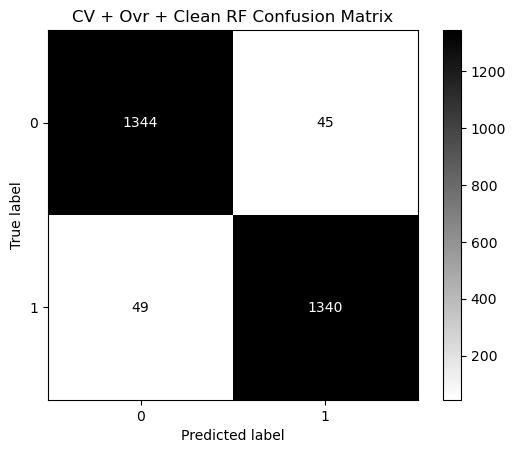

In [29]:
#Oversampled data
df_data = pd.read_csv("alzheimers_disease_cleaned_oversampled.csv")

#separate data in X and y variables
df_X = df_data.drop(["Diagnosis"],axis=1)
df_y = df_data["Diagnosis"]

#accumulative accuracy
cv_ovr_acc = 0

for x in range(1,11):
    #creating k-fold splits
    #must do this because it has the shuffle feature like trian_test_split
    kf = KFold(n_splits=20, shuffle=True)
    
    #Calculating RF classifier using cross validation
    cv = cross_validate(RandomForestClassifier(n_estimators=50),
                               df_X, df_y, cv=kf)
    cv_ovr_acc += np.average(cv['test_score'])

print(f"avg performance: {cv_ovr_acc / 10}")

#Confusion Matrix
#For CV, to get the confusion matrix, cross_val_predict must be called
y_pred_cv_ovr = cross_val_predict(RandomForestClassifier(n_estimators=50),
                               df_X, df_y, cv=kf)
cm_cv_ovr = confusion_matrix(df_y, y_pred_cv_ovr)
ConfusionMatrixDisplay(confusion_matrix=cm_cv_ovr).plot(cmap='gray_r')
plt.title("CV + Ovr + Clean RF Confusion Matrix")

#save plot
plt.savefig("cv_ovr_clean_cm.png", dpi=300)

plt.show()


## _**Feature Selection Conclusion**_

1. Removing the 11 irrelevant features did not have a significant impact on the overall performance of the model.
2. Using only the 5 most relevant features resulted in the approximately the same performance as when all or some of the features were used.
3. The model using the "cleaned" and oversampled dataset using CV will be used for the stacking model because it had the best performance while using the least amount of resources.
